<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Requirements

!sudo apt-get -qq install gifsicle
!pip install tensorflow-gan tensorflow-addons imageio pygifsicle -q
!rm -rf sample_data checkpoints samples BigGANUtils
!mkdir checkpoints samples
!git clone -q https://github.com/xarvel/BigGANUtils.git

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package gifsicle.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../gifsicle_1.91-2_amd64.deb ...
Unpacking gifsicle (1.91-2) ...
Setting up gifsicle (1.91-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 367 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 16.5 MB/s 


In [ ]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Flatten, Embedding, ReLU
from tensorflow.keras.layers import BatchNormalization, Reshape, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import tensorflow_datasets as tfds
from tqdm import tqdm 
import tensorflow_addons as tfa
import functools

from BigGANUtils.SelfAttention import SelfAttention
from BigGANUtils.GBlock import GBlock
from BigGANUtils.DBlock import DBlock
from BigGANUtils.SpectralNormalization import SpectralNormalization
from BigGANUtils.ConditionalBatchNormalization import ConditionalBatchNormalization
from BigGANUtils.SNDense import SNDense 
from BigGANUtils.SNConv2D import SNConv2D
from BigGANUtils.SNEmbedding import SNEmbedding
from BigGANUtils.sample_images import sample_images
from BigGANUtils.sample_single_image import sample_single_image
from BigGANUtils.combine_samples import combine_samples
from BigGANUtils.model_to_img import model_to_img
from BigGANUtils.make_distributed_train_step import make_distributed_train_step

print(tf.__version__)

2.9.2


In [ ]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
#@title CONFIG

IMAGE_SIZE = 64
IMAGE_CHANNELS = 3 
DATASET_SIZE = 13262
BUFFER_SIZE = DATASET_SIZE
PER_REPILICA_BATCH_SIZE = 8
GLOBAL_BATCH_SIZE = PER_REPILICA_BATCH_SIZE * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = DATASET_SIZE // PER_REPILICA_BATCH_SIZE
EPOCHS = 40
TOTAL_TRAINING_ITERATIONS = STEPS_PER_EPOCH * EPOCHS
LATENT_DIM = 120
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 10
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'
SAMPLE_INTERVAL = 1

GAN_FILTERS = 64
GENERATOR_LR = 0.0001
DISCRIMINATOR_LR = 0.0004
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.99
ADAM_EPSILON = 1e-07
SN_EPSILON = 1e-12
BN_EPSILON = 0.001

EMA_DECAY = 0.99
EMA_START = 20000

In [ ]:
tf.random.set_seed(SEED)

weight_initializer = tf.keras.initializers.Orthogonal(seed=SEED)
fixed_noise = tf.random.truncated_normal((LATENT_DIM,), stddev=1)

In [ ]:
#@title Dataset

def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label

    def augment(image, label):
      image = tf.image.random_flip_left_right(
          image, seed=SEED
      )

      return image, label  
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True, seed=SEED)
      dataset = dataset.repeat()
      dataset = dataset.map(augment)

    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=GLOBAL_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [ ]:
#@title Generator

class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size, **kwargs):
    super(Generator, self).__init__(**kwargs)

    self.batch_normalization = tf.keras.layers.experimental.SyncBatchNormalization
    self.channels = channels
    self.dense = SNDense
    self.conv2d = SNConv2D
    self.sn_epsilon = SN_EPSILON
    self.bn_epsilon = BN_EPSILON

    self.linear = self.dense(
        units = 4 * 4 * 16 * channels, 
        use_bias=False, 
        kernel_initializer=weight_initializer, 
        sn_epsilon=self.sn_epsilon, 
        name='linear'
    )
    self.reshape = Reshape([4, 4, 16 * channels], name='reshape')
    self.res_block_1 = GBlock(
        out_channels = 16 * channels, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        dense=self.dense, 
        batch_normalization=self.batch_normalization,
        bn_epsilon=self.bn_epsilon, 
        sn_epsilon=self.sn_epsilon, 
        name='res_block_1'
    )
    self.res_block_2 = GBlock(
        out_channels = 8 * channels, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        dense=self.dense,
        batch_normalization=self.batch_normalization,
        bn_epsilon=self.bn_epsilon, 
        sn_epsilon=self.sn_epsilon, 
        name='res_block_2'
    )
    self.res_block_3 = GBlock(
        out_channels = 4 * channels, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        dense=self.dense, 
        batch_normalization=self.batch_normalization,
        bn_epsilon=self.bn_epsilon, 
        sn_epsilon=self.sn_epsilon, 
        name='res_block_3'
    )
    self.attention = SelfAttention(
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon, 
        name='attention'
    )
    self.res_block_4 = GBlock(
        out_channels = 2 * channels, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        dense=self.dense,
        batch_normalization=self.batch_normalization,
        bn_epsilon=self.bn_epsilon, 
        sn_epsilon=self.sn_epsilon, 
        name='res_block_4'
    )
    self.embedding = Embedding(
        input_dim = num_classes, 
        output_dim = embedding_size, 
        embeddings_initializer=weight_initializer, 
        name='embedding'
    )
    self.bn = self.batch_normalization(name='batch_normalization', epsilon=self.bn_epsilon)
    self.relu = ReLU(name='activation_relu')
    self.conv = self.conv2d(
        filters=IMAGE_CHANNELS, 
        kernel_size=3, 
        padding='same', 
        kernel_initializer=weight_initializer, 
        name='conv', 
        sn_epsilon=self.sn_epsilon
    )
    self.concat = Concatenate(name='concatenate');
    self.tanh = Activation('tanh', name = 'tanh');

  def call(self, inputs, training=None):    
    z, label = inputs   
    z_split = tf.split(z, num_or_size_splits=5, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1([x, conds[0]], training=training)
    x = self.res_block_2([x, conds[1]], training=training)
    x = self.res_block_3([x, conds[2]], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_4([x, conds[3]], training=training)
    x = self.bn(x, training=training)
    x = self.relu(x)
    x = self.conv(x, training=training)
    return self.tanh(x)

In [ ]:
#@title Discriminator

class Discriminator(Model):
  def __init__(self, 
      channels, 
      num_classes, 
      dense = SNDense, 
      conv2d=SNConv2D,  
      embedding=SNEmbedding,
      sn_epsilon=SN_EPSILON,
      bn_epsilon=BN_EPSILON,
      **kwargs
    ):
    super(Discriminator, self).__init__(**kwargs)

    self.dense = dense
    self.conv2d = conv2d
    self.embedding = SNEmbedding
    self.sn_epsilon = sn_epsilon
    self.bn_epsilon = bn_epsilon

    self.res_block_1 = DBlock(
        out_channels = 1 * channels, 
        downsample=True, 
        preactivation=False, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon, 
        name='res_block_1'
    )
    self.res_block_2 = DBlock(
        out_channels = 2 * channels, 
        downsample=True, 
        preactivation=True, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon,
        name='res_block_2'
    )
    self.res_block_3 = DBlock(
        out_channels = 4 * channels, 
        downsample=True, 
        preactivation=True, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon,
        name='res_block_3'
    )
    self.res_block_4 = DBlock(
        out_channels = 8 * channels, 
        downsample=True, 
        preactivation=True, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon,
        name='res_block_4'
    )
    self.attention = SelfAttention(
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon,
        name='attention'
    )
    self.res_block_5 = DBlock(
        out_channels = 16 * channels, 
        downsample=False, 
        preactivation=True, 
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon,
        name='res_block_5'
    )
    self.relu = ReLU(name='relu')
    self.embedding_1 = self.embedding(
        input_dim = num_classes, 
        output_dim = 16 * channels, 
        embeddings_initializer=weight_initializer, 
        sn_epsilon=self.sn_epsilon,
        name='embedding'
    )
    self.linear = self.dense(
        units = 1, 
        kernel_initializer=weight_initializer, 
        sn_epsilon=self.sn_epsilon, 
        name='linear'
    )
  
  @tf.function
  def call(self, inputs, training=False):
    x, label = inputs
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.relu(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding_1(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [ ]:
with strategy.scope():
  generator = Generator(GAN_FILTERS, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM, name='generator')
  generator.build(input_shape=[(None, LATENT_DIM,), (None,)])
  discriminator = Discriminator(GAN_FILTERS, num_classes=NUM_CLASSES, name='discriminator')

In [ ]:
train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=PER_REPILICA_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [ ]:
def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = tf.reduce_mean(tf.nn.relu(1.0 - logits_real))
  fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + logits_fake))
  return real_loss / GLOBAL_BATCH_SIZE , fake_loss / GLOBAL_BATCH_SIZE

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = -tf.reduce_mean(logits_fake)
  
  return loss / GLOBAL_BATCH_SIZE

In [ ]:
with strategy.scope():
  generator_optimizer = tfa.optimizers.MovingAverage(Adam(
      learning_rate=GENERATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON
  ), average_decay=EMA_DECAY, start_step=EMA_START)
  
  discriminator_optimizer = Adam(
      learning_rate=DISCRIMINATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2, 
      epsilon=ADAM_EPSILON
  )

In [ ]:
def sample_analytics(meta, save=False, show=True):
  history = meta['history']

  with plt.xkcd():
    fig, axs = plt.subplots(figsize=(10,10))
    plt.plot(history['gen_loss'], label='Generator loss')
    plt.plot(history['disc_loss_fake'], label='Discriminator loss fake')
    plt.plot(history['disc_loss_real'], label='Discriminator loss real')
    plt.title('Training process')
    
    plt.figtext(.7, .17, '\n'.join([
        'Epoch=%s' % meta['epoch'],
        "GEN_LR=%s" % GENERATOR_LR,
        'DISC_LR=%s' % DISCRIMINATOR_LR,
        'FILTERS=%s' % GAN_FILTERS,
        'PER_REPILICA_BATCH_SIZE=%s' % PER_REPILICA_BATCH_SIZE
    ]))

    fig.legend();

    if save:
      fig.savefig(SAMPLES_DIR + '/analytics_at_epoch_{:04d}.png'.format(meta['epoch'])) 
  
    if show:   
      plt.show()
    else:
      plt.close(fig)

In [ ]:
sample_images = functools.partial(
    sample_images,
    num_classes = NUM_CLASSES,
    image_size = IMAGE_SIZE,
    noise = fixed_noise,
    generator = generator,
    save_dir = SAMPLES_DIR,
    zoom=2
)

In [ ]:
#@title checkpoint
import json

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)

defaultMeta = {
    "history": {
        "disc_loss_real": [],
        "disc_loss_fake": [],
        "gen_loss": []
    },
    "epoch": 1
}
meta = defaultMeta

META_FILE = CHECKPOINT_DIR + '/meta.json'

def restore_checkpoint():
  try:
    with open(META_FILE) as f:
      meta = json.load(f)
      meta['epoch'] += 1
  except:
    meta = defaultMeta
    pass
  
  status = checkpoint.restore(latest_checkpoint, options=local_device_option)
  return meta

def save_checkpoint():
  print('Saving checkpoint');

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

  with open(META_FILE, 'w') as f:
    json.dump(meta, f)
  
  checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

meta = restore_checkpoint();

(1, 64, 64, 3)


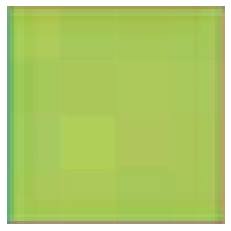

In [ ]:
with strategy.scope():
  label = 6
  generated_image = sample_single_image(
      generator=generator,
      label=label,
      noise=fixed_noise
  ) 

In [ ]:
with strategy.scope():
  labels = tf.constant([label], dtype=tf.int64)
  images = tf.expand_dims(generated_image, axis=0)

  decision = discriminator(images, labels)
  print(decision)

tf.Tensor([[1.9460243]], shape=(1, 1), dtype=float32)


In [ ]:
#@title train_step

train_step = make_distributed_train_step(
  generator=generator,
  discriminator=discriminator,
  discriminator_loss=discriminator_loss,
  generator_loss=generator_loss,
  generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  batch_size=PER_REPILICA_BATCH_SIZE,
  latent_dim=LATENT_DIM,
  strategy=strategy
)

In [ ]:
train_iterator = iter(train_dataset)

for epoch in range(meta['epoch'], EPOCHS + 1):
  meta['epoch'] = epoch
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(STEPS_PER_EPOCH))
  for step in pbar:
    disc_loss_real, disc_loss_fake, gen_loss = train_step(train_iterator)
    meta['history']['disc_loss_real'].append(float(disc_loss_real));
    meta['history']['disc_loss_fake'].append(float(disc_loss_fake));
    meta['history']['gen_loss'].append(float(gen_loss));
    pbar.set_postfix({
        'disc_loss_real': round(float(disc_loss_real), 4), 
        'disc_loss_fake': round(float(disc_loss_fake), 4), 
        'gen_loss': round(float(gen_loss), 4)
    })
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % SAMPLE_INTERVAL == 0:
    with strategy.scope():
      generator_optimizer.swap_weights()
      sample_images(epoch = epoch, save=True, show=False)
      generator_optimizer.swap_weights()
    
  if epoch % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()
    sample_analytics(meta, save=True, show=False)   

  print('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

Epoch: 1/40


Current step 1657: 100%|██████████| 1657/1657 [05:54<00:00,  4.68it/s, disc_loss_real=0.0027, disc_loss_fake=0.0041, gen_loss=0.0141]


Time for epoch 1 is 361.8747615814209 sec
Epoch: 2/40


Current step 3314: 100%|██████████| 1657/1657 [02:32<00:00, 10.83it/s, disc_loss_real=0.002, disc_loss_fake=0, gen_loss=0.0342]


Time for epoch 2 is 160.94337248802185 sec
Epoch: 3/40


Current step 4971: 100%|██████████| 1657/1657 [02:33<00:00, 10.78it/s, disc_loss_real=0.0204, disc_loss_fake=0.0003, gen_loss=0.0361]


Time for epoch 3 is 158.87315368652344 sec
Epoch: 4/40


Current step 6628: 100%|██████████| 1657/1657 [02:33<00:00, 10.78it/s, disc_loss_real=0.0052, disc_loss_fake=0.0013, gen_loss=0.0288]


Time for epoch 4 is 159.07671356201172 sec
Epoch: 5/40


Current step 8285: 100%|██████████| 1657/1657 [02:31<00:00, 10.90it/s, disc_loss_real=0.0096, disc_loss_fake=0.0004, gen_loss=0.0359]


Time for epoch 5 is 158.5468304157257 sec
Epoch: 6/40


Current step 9942: 100%|██████████| 1657/1657 [02:32<00:00, 10.90it/s, disc_loss_real=0.004, disc_loss_fake=0.0016, gen_loss=0.0286]


Time for epoch 6 is 157.58959007263184 sec
Epoch: 7/40


Current step 11599: 100%|██████████| 1657/1657 [02:33<00:00, 10.81it/s, disc_loss_real=0.0173, disc_loss_fake=0.0008, gen_loss=0.0348]


Time for epoch 7 is 158.51770853996277 sec
Epoch: 8/40


Current step 13256: 100%|██████████| 1657/1657 [02:31<00:00, 10.92it/s, disc_loss_real=0.0017, disc_loss_fake=0.0025, gen_loss=0.0258]


Time for epoch 8 is 158.7174470424652 sec
Epoch: 9/40


Current step 14913: 100%|██████████| 1657/1657 [02:33<00:00, 10.81it/s, disc_loss_real=0.0002, disc_loss_fake=0.0132, gen_loss=0.0056]


Time for epoch 9 is 158.50306367874146 sec
Epoch: 10/40


Current step 16570: 100%|██████████| 1657/1657 [02:32<00:00, 10.89it/s, disc_loss_real=0.0036, disc_loss_fake=0.0016, gen_loss=0.0288]


Saving checkpoint
Time for epoch 10 is 166.35081887245178 sec
Epoch: 11/40


Current step 18227: 100%|██████████| 1657/1657 [02:34<00:00, 10.72it/s, disc_loss_real=0.006, disc_loss_fake=0.0005, gen_loss=0.0335]


Time for epoch 11 is 160.1697883605957 sec
Epoch: 12/40


Current step 19884: 100%|██████████| 1657/1657 [02:34<00:00, 10.70it/s, disc_loss_real=0.0057, disc_loss_fake=0.001, gen_loss=0.0352]


Time for epoch 12 is 160.47824931144714 sec
Epoch: 13/40


Current step 21541: 100%|██████████| 1657/1657 [02:34<00:00, 10.75it/s, disc_loss_real=0.0098, disc_loss_fake=0.0009, gen_loss=0.0302]


Time for epoch 13 is 163.08272171020508 sec
Epoch: 14/40


Current step 23198: 100%|██████████| 1657/1657 [02:34<00:00, 10.75it/s, disc_loss_real=0.0008, disc_loss_fake=0.0119, gen_loss=0.0063]


Time for epoch 14 is 159.5213484764099 sec
Epoch: 15/40


Current step 24855: 100%|██████████| 1657/1657 [02:34<00:00, 10.73it/s, disc_loss_real=0.0095, disc_loss_fake=0.0015, gen_loss=0.0328]


Time for epoch 15 is 159.93541526794434 sec
Epoch: 16/40


Current step 26512: 100%|██████████| 1657/1657 [02:33<00:00, 10.77it/s, disc_loss_real=0.0014, disc_loss_fake=0.0081, gen_loss=0.0135]


Time for epoch 16 is 159.51429843902588 sec
Epoch: 17/40


Current step 28169: 100%|██████████| 1657/1657 [02:34<00:00, 10.74it/s, disc_loss_real=0.0017, disc_loss_fake=0.0047, gen_loss=0.0206]


Time for epoch 17 is 159.4862744808197 sec
Epoch: 18/40


Current step 29826: 100%|██████████| 1657/1657 [02:34<00:00, 10.70it/s, disc_loss_real=0.0021, disc_loss_fake=0.009, gen_loss=0.0114]


Time for epoch 18 is 163.76591181755066 sec
Epoch: 19/40


Current step 31483: 100%|██████████| 1657/1657 [02:34<00:00, 10.74it/s, disc_loss_real=0, disc_loss_fake=0.0151, gen_loss=0.0043]


Time for epoch 19 is 160.24864053726196 sec
Epoch: 20/40


Current step 33140: 100%|██████████| 1657/1657 [02:32<00:00, 10.85it/s, disc_loss_real=0.001, disc_loss_fake=0.012, gen_loss=0.0068]


Saving checkpoint
Time for epoch 20 is 165.51239943504333 sec
Epoch: 21/40


Current step 34797: 100%|██████████| 1657/1657 [02:33<00:00, 10.81it/s, disc_loss_real=0.0073, disc_loss_fake=0.0022, gen_loss=0.0312]


Time for epoch 21 is 158.87264776229858 sec
Epoch: 22/40


Current step 36454: 100%|██████████| 1657/1657 [02:33<00:00, 10.79it/s, disc_loss_real=0.0013, disc_loss_fake=0.0053, gen_loss=0.0172]


Time for epoch 22 is 159.0041618347168 sec
Epoch: 23/40


Current step 38111: 100%|██████████| 1657/1657 [02:34<00:00, 10.76it/s, disc_loss_real=0.001, disc_loss_fake=0.0082, gen_loss=0.013]


Time for epoch 23 is 159.48212051391602 sec
Epoch: 24/40


Current step 39768: 100%|██████████| 1657/1657 [02:35<00:00, 10.64it/s, disc_loss_real=0.0049, disc_loss_fake=0.003, gen_loss=0.0231]


Time for epoch 24 is 161.39063715934753 sec
Epoch: 25/40


Current step 41425: 100%|██████████| 1657/1657 [02:36<00:00, 10.57it/s, disc_loss_real=0.0021, disc_loss_fake=0.004, gen_loss=0.019]


Time for epoch 25 is 167.5453622341156 sec
Epoch: 26/40


Current step 43082: 100%|██████████| 1657/1657 [02:36<00:00, 10.57it/s, disc_loss_real=0.0024, disc_loss_fake=0.0028, gen_loss=0.0242]


Time for epoch 26 is 162.22300624847412 sec
Epoch: 27/40


Current step 44739: 100%|██████████| 1657/1657 [02:34<00:00, 10.72it/s, disc_loss_real=0.0039, disc_loss_fake=0.0016, gen_loss=0.027]


Time for epoch 27 is 159.96152424812317 sec
Epoch: 28/40


Current step 46396: 100%|██████████| 1657/1657 [02:34<00:00, 10.74it/s, disc_loss_real=0.002, disc_loss_fake=0.0092, gen_loss=0.0146]


Time for epoch 28 is 159.94613027572632 sec
Epoch: 29/40


Current step 48053: 100%|██████████| 1657/1657 [02:34<00:00, 10.70it/s, disc_loss_real=0.0013, disc_loss_fake=0.0062, gen_loss=0.0163]


Time for epoch 29 is 160.30519938468933 sec
Epoch: 30/40


Current step 49710: 100%|██████████| 1657/1657 [02:34<00:00, 10.71it/s, disc_loss_real=0.0069, disc_loss_fake=0.0005, gen_loss=0.0384]


Saving checkpoint
Time for epoch 30 is 168.1891906261444 sec
Epoch: 31/40


Current step 51367: 100%|██████████| 1657/1657 [02:35<00:00, 10.62it/s, disc_loss_real=0.001, disc_loss_fake=0.0056, gen_loss=0.0186]


Time for epoch 31 is 161.59890341758728 sec
Epoch: 32/40


Current step 53024: 100%|██████████| 1657/1657 [02:35<00:00, 10.67it/s, disc_loss_real=0.0039, disc_loss_fake=0.002, gen_loss=0.0337]


Time for epoch 32 is 160.9573678970337 sec
Epoch: 33/40


Current step 54681: 100%|██████████| 1657/1657 [02:35<00:00, 10.63it/s, disc_loss_real=0.0038, disc_loss_fake=0.0026, gen_loss=0.0313]


Time for epoch 33 is 166.5696382522583 sec
Epoch: 34/40


Current step 56338: 100%|██████████| 1657/1657 [02:36<00:00, 10.62it/s, disc_loss_real=0.0047, disc_loss_fake=0.0014, gen_loss=0.0339]


Time for epoch 34 is 161.45841312408447 sec
Epoch: 35/40


Current step 57995: 100%|██████████| 1657/1657 [02:35<00:00, 10.62it/s, disc_loss_real=0.0015, disc_loss_fake=0.0015, gen_loss=0.0309]


Time for epoch 35 is 161.63866543769836 sec
Epoch: 36/40


Current step 59652: 100%|██████████| 1657/1657 [02:39<00:00, 10.38it/s, disc_loss_real=0.0006, disc_loss_fake=0.0028, gen_loss=0.0256]


Time for epoch 36 is 165.0756552219391 sec
Epoch: 37/40


Current step 61309: 100%|██████████| 1657/1657 [02:34<00:00, 10.71it/s, disc_loss_real=0.0004, disc_loss_fake=0.0061, gen_loss=0.0179]


Time for epoch 37 is 160.40136909484863 sec
Epoch: 38/40


Current step 62966: 100%|██████████| 1657/1657 [02:37<00:00, 10.51it/s, disc_loss_real=0.004, disc_loss_fake=0.0004, gen_loss=0.0407]


Time for epoch 38 is 163.14727139472961 sec
Epoch: 39/40


Current step 64623: 100%|██████████| 1657/1657 [02:35<00:00, 10.64it/s, disc_loss_real=0.0004, disc_loss_fake=0.0065, gen_loss=0.0197]


Time for epoch 39 is 161.15168499946594 sec
Epoch: 40/40


Current step 66280: 100%|██████████| 1657/1657 [02:35<00:00, 10.62it/s, disc_loss_real=0.0007, disc_loss_fake=0.0042, gen_loss=0.0226]


Saving checkpoint
Time for epoch 40 is 169.78670358657837 sec


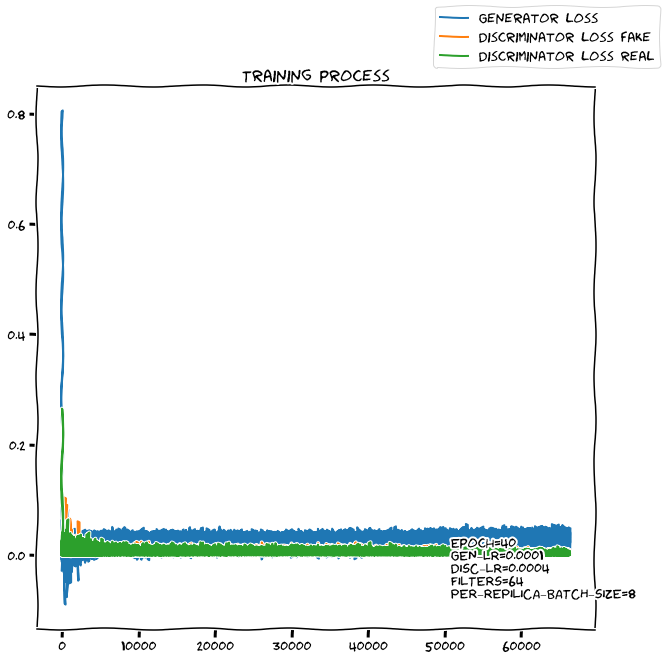

In [ ]:
sample_analytics(meta, save=False, show=True)    

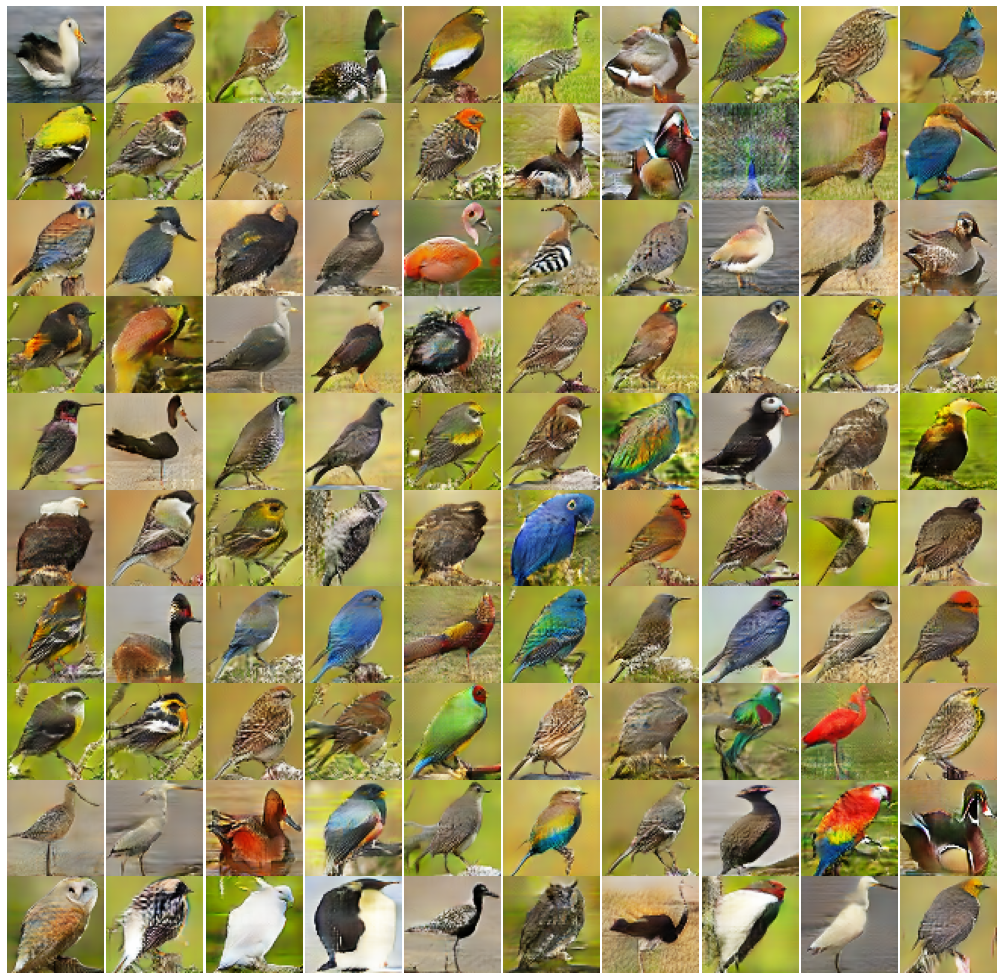

In [ ]:
with strategy.scope():
  generator_optimizer.swap_weights()
  sample_images(epoch = meta['epoch'], save=False, show=True)
  generator_optimizer.swap_weights()

In [ ]:
combine_samples(SAMPLES_DIR, 'image_at_epoch_*.jpeg')